In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

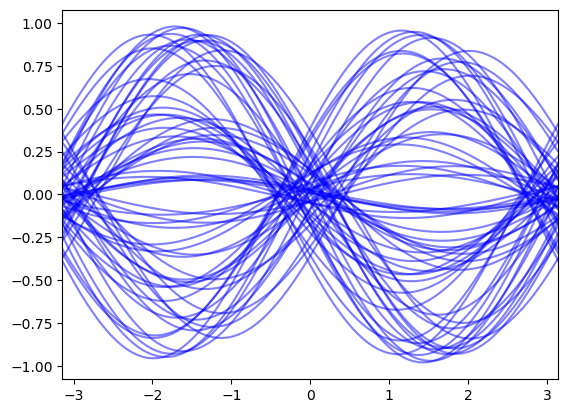

In [2]:
from datasets import SineData
from math import pi

# Create dataset
dataset = SineData(amplitude_range=(-1., 1.),
                   shift_range=(-.5, .5),
                   num_samples=2000)

# Visualize data samples
for i in range(64):
    x, y = dataset[i] 
    plt.plot(x.numpy(), y.numpy(), c='b', alpha=0.5)
    plt.xlim(-pi, pi)

In [25]:
from np import NeuralProcess

x_dim = 1
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder

model = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim, 2, 2).to(device)

tensor([[[0.0377],
         [0.0389],
         [0.0398],
         [0.0407],
         [0.0416],
         [0.0425],
         [0.0434],
         [0.0443],
         [0.0452],
         [0.0461],
         [0.0470],
         [0.0479],
         [0.0488],
         [0.0496],
         [0.0504],
         [0.0509],
         [0.0513],
         [0.0517],
         [0.0522],
         [0.0526],
         [0.0530],
         [0.0534],
         [0.0538],
         [0.0543],
         [0.0547],
         [0.0551],
         [0.0555],
         [0.0561],
         [0.0568],
         [0.0575],
         [0.0581],
         [0.0586],
         [0.0590],
         [0.0594],
         [0.0597],
         [0.0600],
         [0.0601],
         [0.0601],
         [0.0601],
         [0.0601],
         [0.0601],
         [0.0600],
         [0.0600],
         [0.0601],
         [0.0606],
         [0.0611],
         [0.0616],
         [0.0621],
         [0.0626],
         [0.0631],
         [0.0638],
         [0.0647],
         [0.

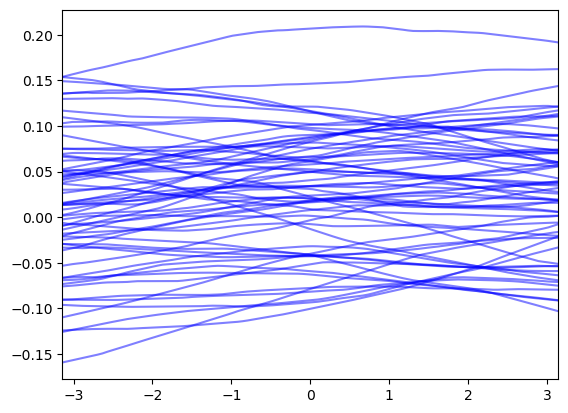

In [28]:
# Create a set of 100 target points, with shape 
# (batch_size, num_points, x_dim), which in this case is
# (1, 100, 1)
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))  # Shape (batch_size, z_dim)
    z_sample = z_sample.unsqueeze(1).expand(-1, 100, -1)
    # Map x_target and z to p_y_target (which is parameterized by a 
    # normal with mean mu and std dev sigma)
    output = model.decoder(torch.cat((x_target, z_sample), dim=2).to(device))
    mu, log_var = output.chunk(2, dim=-1)
    print(mu)
    print(mu.shape)
    sigma = torch.exp(0.5*log_var)
    # Plot predicted mean at each target point (note we could also
    # sample from distribution but plot mean for simplicity)
    plt.plot(x_target.cpu().numpy()[0], mu.cpu().detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)

In [122]:
from torch.utils.data import DataLoader
from torch.distributions.kl import kl_divergence
from utils import context_target_split
from random import randint

def _loss(p_y_pred, y_target, q_target, q_context):
        """
        Computes Neural Process loss.

        Parameters
        ----------
        p_y_pred : one of torch.distributions.Distribution
            Distribution over y output by Neural Process.

        y_target : torch.Tensor
            Shape (batch_size, num_target, y_dim)

        q_target : one of torch.distributions.Distribution
            Latent distribution for target points.

        q_context : one of torch.distributions.Distribution
            Latent distribution for context points.
        """
        # Log likelihood has shape (batch_size, num_target, y_dim). Take mean
        # over batch and sum over number of targets and dimensions of y
        log_likelihood = p_y_pred.log_prob(y_target).mean(dim=0).sum()
        # KL has shape (batch_size, r_dim). Take mean over batch and sum over
        # r_dim (since r_dim is dimension of normal distribution)
        kl = kl_divergence(q_target, q_context).mean(dim=0).sum()
        return -log_likelihood + kl

batch_size = 2
num_context = 10
num_target = 10
num_context_range=(num_context, num_context)
num_extra_target_range=(num_target, num_target)

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
model.training = True
for epoch in range(20):
    epoch_loss = 0.

    for x, y in data_loader:
        optimizer.zero_grad()

        num_context = randint(*num_context_range)
        num_extra_target = randint(*num_extra_target_range)

        x_context, y_context, x_target, y_target = context_target_split(x, y, num_context, num_extra_target)
        x_context = x_context.to(device)
        y_context = y_context.to(device)
        x_target = x_target.to(device)
        y_target = y_target.to(device)

        p_y_pred, q_target, q_context = model(x_context, y_context, x_target, y_target)

        loss = _loss(p_y_pred, torch.cat((y_context, y_target), dim=1), q_target, q_context)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}: Avg. Loss = {epoch_loss / len(data_loader)}")



Epoch 1: Avg. Loss = -23.110832595467567
Epoch 2: Avg. Loss = -24.80947387522459
Epoch 3: Avg. Loss = -25.492754883855582
Epoch 4: Avg. Loss = -26.96131070637703
Epoch 5: Avg. Loss = -27.870127984344958
Epoch 6: Avg. Loss = -28.073932255387305
Epoch 7: Avg. Loss = -29.039519186735152
Epoch 8: Avg. Loss = -28.549082339048386
Epoch 9: Avg. Loss = -29.776785253584386
Epoch 10: Avg. Loss = -29.60922263598442
Epoch 11: Avg. Loss = -30.155128356933595
Epoch 12: Avg. Loss = -29.878589703679086
Epoch 13: Avg. Loss = -30.455197244167326
Epoch 14: Avg. Loss = -30.51802622127533
Epoch 15: Avg. Loss = -30.791814373612404
Epoch 16: Avg. Loss = -30.68163172638416
Epoch 17: Avg. Loss = -31.411957327604295
Epoch 18: Avg. Loss = -31.604374776244164
Epoch 19: Avg. Loss = -31.889742556095122
Epoch 20: Avg. Loss = -32.57701621574164


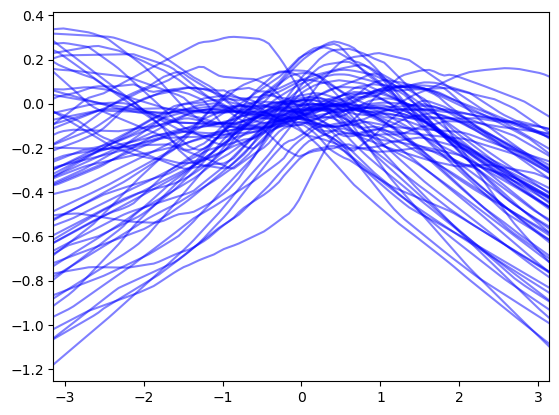

In [123]:
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))
    z_sample = z_sample.unsqueeze(1).expand(-1, 100, -1)
    #xz = torch.cat((x_context, z_context), dim=2).to(device).float()
    xz = torch.cat((x_target, z_sample), dim=2).to(device).float()
    output = model.decoder(xz)

    mu, _ = output.chunk(2, dim=-1)
    plt.plot(x_target.cpu().numpy()[0], mu.detach().cpu().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)

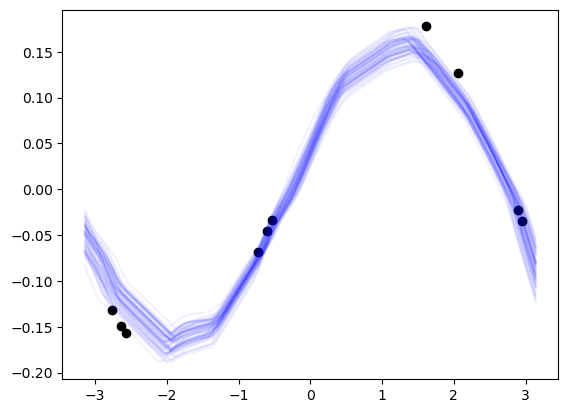

In [152]:
from utils import context_target_split

# Extract a batch from data_loader
for batch in data_loader:
    break

# Use batch to create random set of context points
x, y = batch
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)

# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

x_context = x_context.to(device)
y_context = y_context.to(device)
x_target = x_target.to(device)

model.training = False

for i in range(64):
    # Neural process returns distribution over y_target
    p_y_pred = model(x_context, y_context, x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    plt.plot(x_target.cpu().numpy()[0], mu.cpu().numpy()[0], 
             alpha=0.05, c='b')

plt.scatter(x_context[0].cpu().numpy(), y_context[0].cpu().numpy(), c='k')